In [1]:
!pip install -Uqq Pillow
!pip install -Uqq fastbook
!pip install -Uqq timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 43.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.
plotnine 0.14.4 requires matplotlib>=3.8.0, but you have matplotlib 3.7.5 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.1/124.1 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.9/246.9 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 32.8 MB/s eta 0:00:00


In [2]:
from fastai.vision.learner import *
from fastai.vision.all import *
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

In [3]:
def finding(x): return x[0].isupper()

xrays = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224))

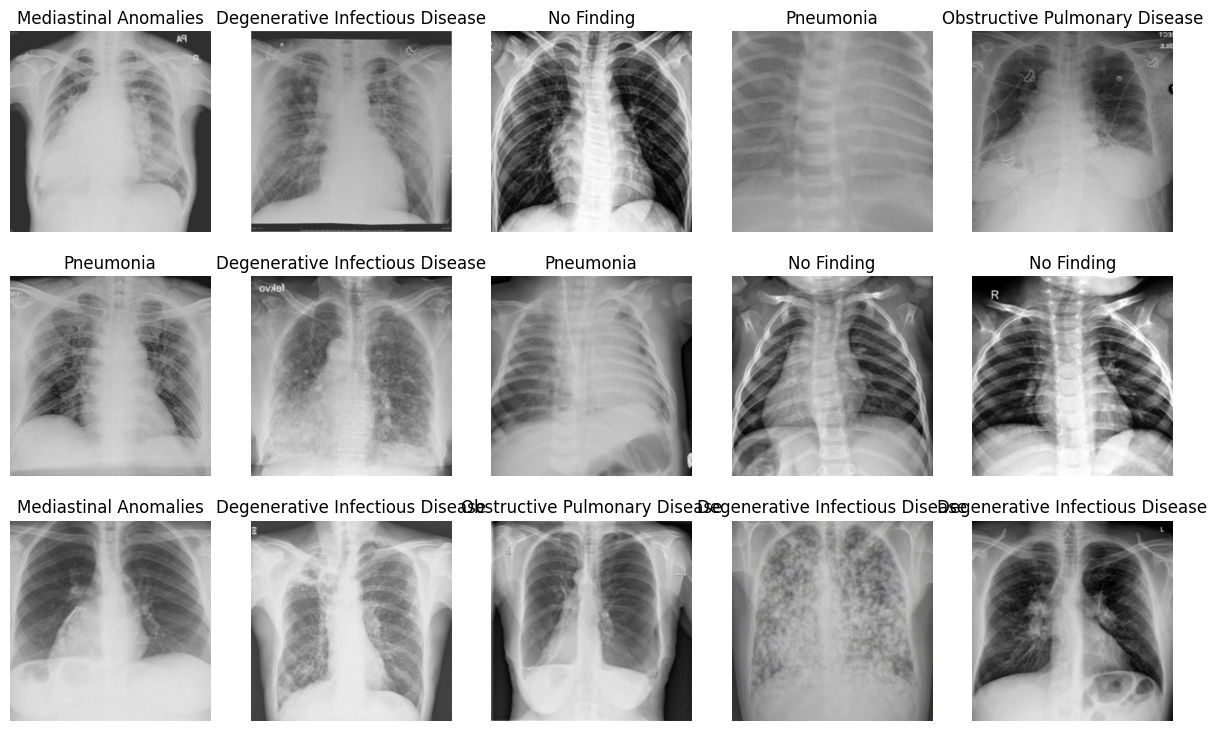

In [4]:
path = '/kaggle/input/chest-xrays-5-classes/archive'
dls = xrays.dataloaders(path, label_func=finding)
dls.valid.show_batch(max_n=15, nrows=3)

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.163752,0.410556,0.117021,01:31


epoch,train_loss,valid_loss,error_rate,time
0,0.421959,0.259453,0.080378,02:16
1,0.321064,0.159875,0.049645,02:16
2,0.222596,0.107493,0.036643,02:16
3,0.134794,0.064353,0.017730,02:15
4,0.085026,0.044315,0.017730,02:16
5,0.051626,0.042522,0.010638,02:16
6,0.029889,0.031087,0.008274,02:16
7,0.022974,0.028522,0.009456,02:16
8,0.015467,0.026413,0.008274,02:16
9,0.014276,0.025083,0.007092,02:16


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

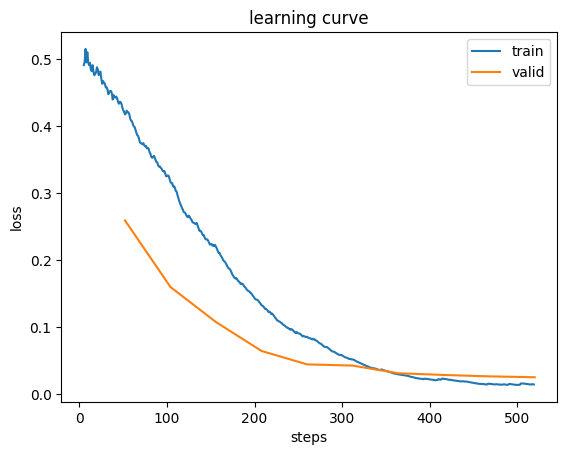

In [5]:
learn = vision_learner(dls, 'vit_base_patch16_224.orig_in21k', metrics=error_rate, opt_func=Adam)

learn.fine_tune(epochs=10)
learn.recorder.plot_loss()

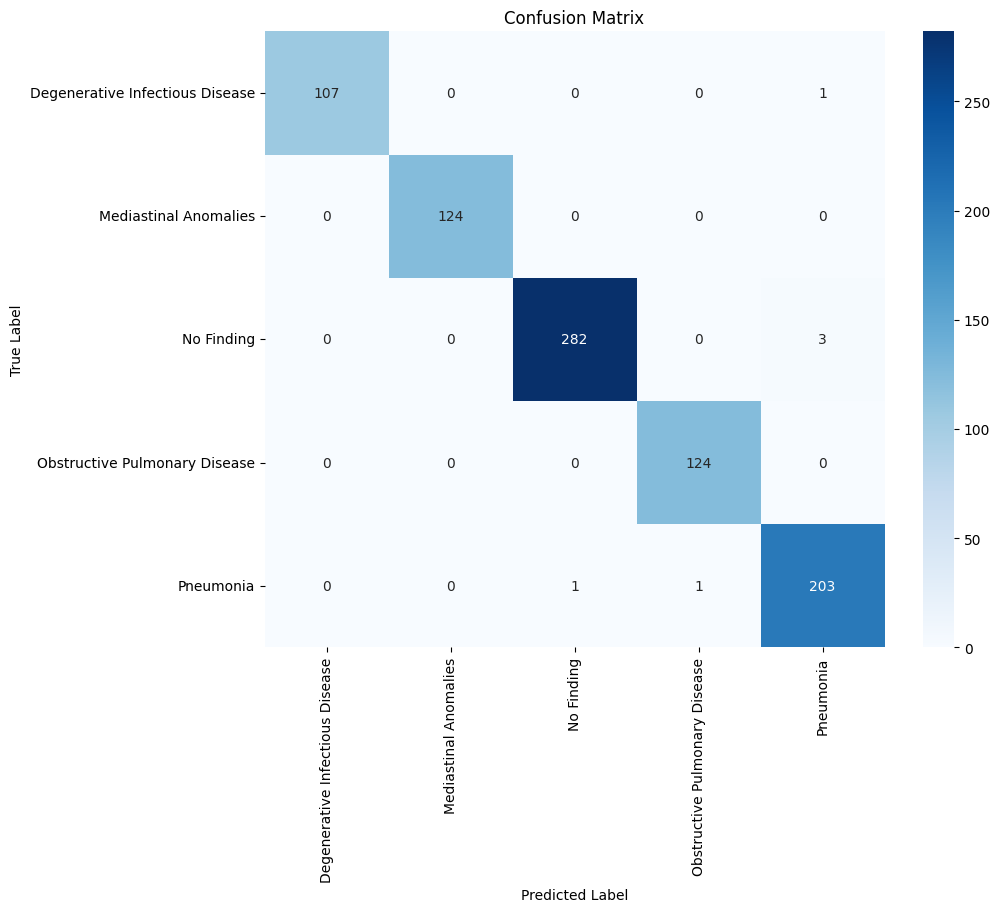


Classification Report:
                                 precision    recall  f1-score     support
Degenerative Infectious Disease   1.000000  0.990741  0.995349  108.000000
Mediastinal Anomalies             1.000000  1.000000  1.000000  124.000000
No Finding                        0.996466  0.989474  0.992958  285.000000
Obstructive Pulmonary Disease     0.992000  1.000000  0.995984  124.000000
Pneumonia                         0.980676  0.990244  0.985437  205.000000
accuracy                          0.992908  0.992908  0.992908    0.992908
macro avg                         0.993829  0.994092  0.993945  846.000000
weighted avg                      0.992955  0.992908  0.992916  846.000000


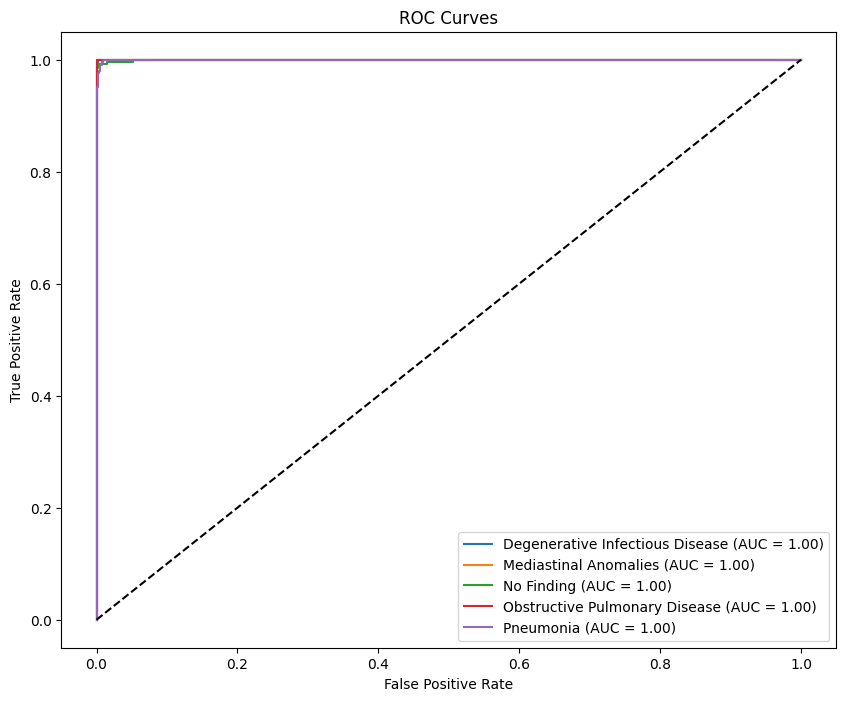

In [6]:
preds, targets = learn.get_preds()
pred_classes = torch.argmax(preds, dim=1)

class_names = learn.dls.vocab

cm = confusion_matrix(targets, pred_classes)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
    
report = classification_report(targets, pred_classes, 
                             target_names=class_names,
                             output_dict=True)
report_df = pd.DataFrame(report).transpose()
print("\nClassification Report:")
print(report_df)

plt.figure(figsize=(10,8))
for i, class_name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(targets == i, preds[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

In [7]:
learn.export('model.pkl')